# 第00章: クイックスタート：最初のMLP実験

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 合成データを生成してMLPで分類できる
- [ ] GridSearchCVでハイパーパラメータを探索できる
- [ ] 決定境界を可視化して理解できる
- [ ] 損失曲線から学習状況を判断できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎（関数、ループ）
- ✅ 基本的なプログラミング経験

⏱️ **推定学習時間**: 30-45分  
📊 **難易度**: ★☆☆☆☆（入門）  
🎓 **カテゴリ**: 導入

---


## 📖 このノートブックで学ぶことこのノートブックは、機械学習の世界への入り口となる「クイックスタート」ガイドです。料理のレシピを初めて見る人が、まず簡単な料理を作ってみるように、機械学習も実際に動かしてみることで理解が深まります。### なぜクイックスタートが重要なのか？機械学習は一見複雑に見えますが、基本的な流れは次のようにシンプルです：1. **データを用意する** - 過去の事例を集める2. **モデルを選ぶ** - 問題に適した道具を選ぶ3. **学習させる** - データからパターンを見つける4. **予測する** - 新しいデータで結果を予測するこのノートブックでは、この基本的な流れを実際に体験することで、機械学習がどのように動くのかを直感的に理解できます。### 実世界での応用例このクイックスタートで学ぶ技術は、以下のような実務でも使われています：- **医療診断**: 症状から病気を予測- **スパムフィルター**: メールが迷惑メールかどうかを判定- **製品推薦**: 顧客の好みを予測して商品を提案- **与信審査**: ローンの返済可能性を予測それでは、実際にコードを動かしながら学んでいきましょう！

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## 1. Generate Synthetic Data

We'll use the `make_moons` dataset - a classic non-linearly separable dataset that's perfect for demonstrating neural network capabilities.

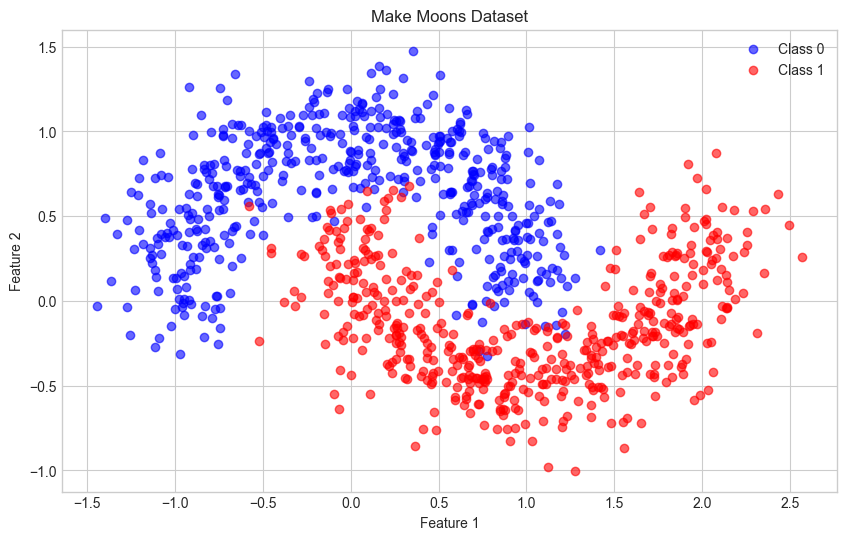

Dataset shape: (1000, 2)
Class distribution: [500 500]


In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate moon-shaped data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0', alpha=0.6)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Make Moons Dataset')
plt.legend()
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

## 2. Preprocess Data

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 200


**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

## 3. Train a Simple MLP

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 📚 モデルの学習について詳しく理解する「学習」とは、モデルがデータからパターンを見つけるプロセスです。#### 学習のプロセス1. **パターンの探索**：   - モデルは訓練データを分析して、特徴とラベルの関係を探します   - 「がく片が長くて花弁が短い → 種類A」のようなルールを見つけます2. **内部パラメータの調整**：   - モデルは見つけたパターンを内部パラメータとして記憶します   - ランダムフォレストの場合、各決定木の分岐ルールが保存されます3. **検証**：   - 訓練データで正しく分類できるか確認します   - エラーが多い場合は、パラメータを調整します#### `.fit()` メソッドの重要性```pythonmodel.fit(X_train, y_train)```この一行で以下のことが行われます：- データの統計的な特性を分析- 最適な分岐点を探索- 100本の決定木をそれぞれ構築- 各木のパラメータを最適化**実行時間**：- 小規模データ（数百〜数千行）：数秒- 中規模データ（数万行）：数十秒〜数分- 大規模データ（数十万行以上）：数分〜数時間#### 料理のたとえ学習は、料理人が何度も試作を重ねてレシピを完成させる過程に似ています：- データ = 過去の試作記録- 学習 = 記録から最適な調理法を見つける- モデル = 完成したレシピ

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [5]:
# Create and train a simple MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(50,),  # One hidden layer with 50 neurons
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)

# Evaluate
train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"\nNumber of iterations: {mlp.n_iter_}")

Training Accuracy: 0.9700
Test Accuracy: 0.9800

Number of iterations: 500


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## 4. Visualize Decision Boundary

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 🎯 予測について詳しく理解する学習したモデルを使って、新しいデータの結果を予測します。#### 予測のプロセス1. **新しいデータの入力**：   - まだ見たことのないデータをモデルに渡します   - データは訓練時と同じ形式である必要があります2. **モデルの適用**：   - モデルは学習したパターンを新しいデータに当てはめます   - 各決定木が個別に予測を行います3. **結果の集約**：   - 100本の木の予測を多数決で決定します   - 最も多くの木が予測したクラスが最終的な予測になります#### 予測の信頼性予測には必ず不確実性があります：- **高い信頼度**：全ての木が同じクラスを予測- **低い信頼度**：木の予測が分かれる実務では、予測の確率も重要です：```python# 予測確率を取得probabilities = model.predict_proba(X_test)# 例：[0.95, 0.03, 0.02] → 95%の確率でクラス0```#### 実世界での応用**医療診断の例**：- 入力：患者の症状データ- 予測：病気の種類- 活用：医師の診断を補助（最終判断は医師が行う）**重要な注意点**：機械学習の予測は100%正確ではありません。常に人間の判断と組み合わせて使うことが重要です。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

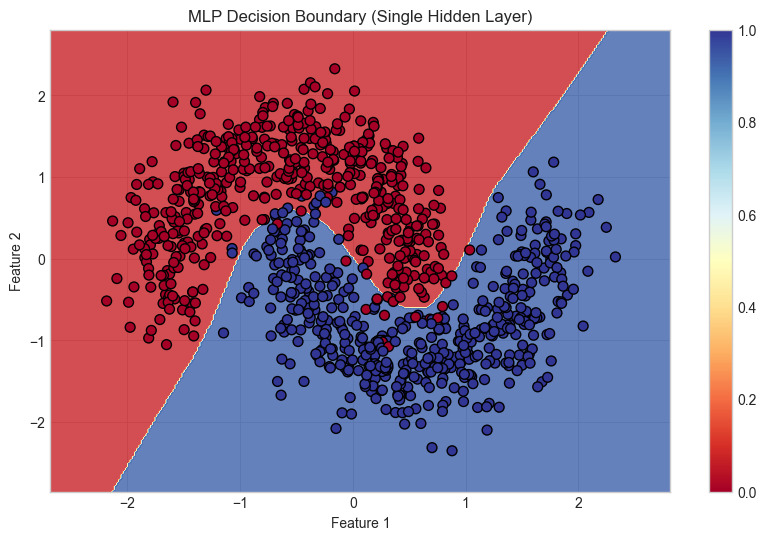

In [6]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """Plot the decision boundary of a classifier."""
    h = 0.02  # Step size in mesh
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_decision_boundary(mlp, X_scaled, y, "MLP Decision Boundary (Single Hidden Layer)")

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## 5. Explore Parameter Space with Grid Search

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 📚 モデルの学習について詳しく理解する「学習」とは、モデルがデータからパターンを見つけるプロセスです。#### 学習のプロセス1. **パターンの探索**：   - モデルは訓練データを分析して、特徴とラベルの関係を探します   - 「がく片が長くて花弁が短い → 種類A」のようなルールを見つけます2. **内部パラメータの調整**：   - モデルは見つけたパターンを内部パラメータとして記憶します   - ランダムフォレストの場合、各決定木の分岐ルールが保存されます3. **検証**：   - 訓練データで正しく分類できるか確認します   - エラーが多い場合は、パラメータを調整します#### `.fit()` メソッドの重要性```pythonmodel.fit(X_train, y_train)```この一行で以下のことが行われます：- データの統計的な特性を分析- 最適な分岐点を探索- 100本の決定木をそれぞれ構築- 各木のパラメータを最適化**実行時間**：- 小規模データ（数百〜数千行）：数秒- 中規模データ（数万行）：数十秒〜数分- 大規模データ（数十万行以上）：数分〜数時間#### 料理のたとえ学習は、料理人が何度も試作を重ねてレシピを完成させる過程に似ています：- データ = 過去の試作記録- 学習 = 記録から最適な調理法を見つける- モデル = 完成したレシピ

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [7]:
# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (20, 10), (50, 25)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01]
}

# Create MLP for grid search
mlp_gs = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Perform grid search
grid_search = GridSearchCV(
    mlp_gs, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(10,), (50,), (100,), (20, 10),
                                                (50, 25)],
                         'learning_rate_init': [0.001, 0.01]},
             return_train_score=True, scoring='accuracy', verbose=1)

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Display results
print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test, y_test):.4f}")

Best Parameters:
  alpha: 0.01
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.01

Best CV Score: 0.9600
Test Score: 0.9750


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## 6. Visualize Grid Search Results

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Convert results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Extract relevant columns
results_df = results_df[[
    'param_hidden_layer_sizes', 
    'param_alpha', 
    'param_learning_rate_init',
    'mean_test_score', 
    'std_test_score',
    'mean_train_score',
    'rank_test_score'
]].sort_values('rank_test_score')

print("Top 10 Parameter Combinations:")
results_df.head(10)

Top 10 Parameter Combinations:


,param_hidden_layer_sizes,param_alpha,param_learning_rate_init,mean_test_score,std_test_score,mean_train_score,rank_test_score
29,"(50, 25)",0.0100,0.01,0.96000,0.018792,0.962500,1
39,"(50, 25)",0.1000,0.01,0.95875,0.018792,0.962500,2
9,"(50, 25)",0.0001,0.01,0.95625,0.018957,0.961875,3
19,"(50, 25)",0.0010,0.01,0.95625,0.018957,0.961875,3
7,"(20, 10)",0.0001,0.01,0.91500,0.033680,0.916875,5
37,"(20, 10)",0.1000,0.01,0.91000,0.038649,0.911875,6
17,"(20, 10)",0.0010,0.01,0.90625,0.041458,0.902500,7
27,"(20, 10)",0.0100,0.01,0.90625,0.041458,0.902187,7
35,"(100,)",0.1000,0.01,0.89625,0.046536,0.904375,9
5,"(100,)",0.0001,0.01,0.89500,0.044616,0.903750,10


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

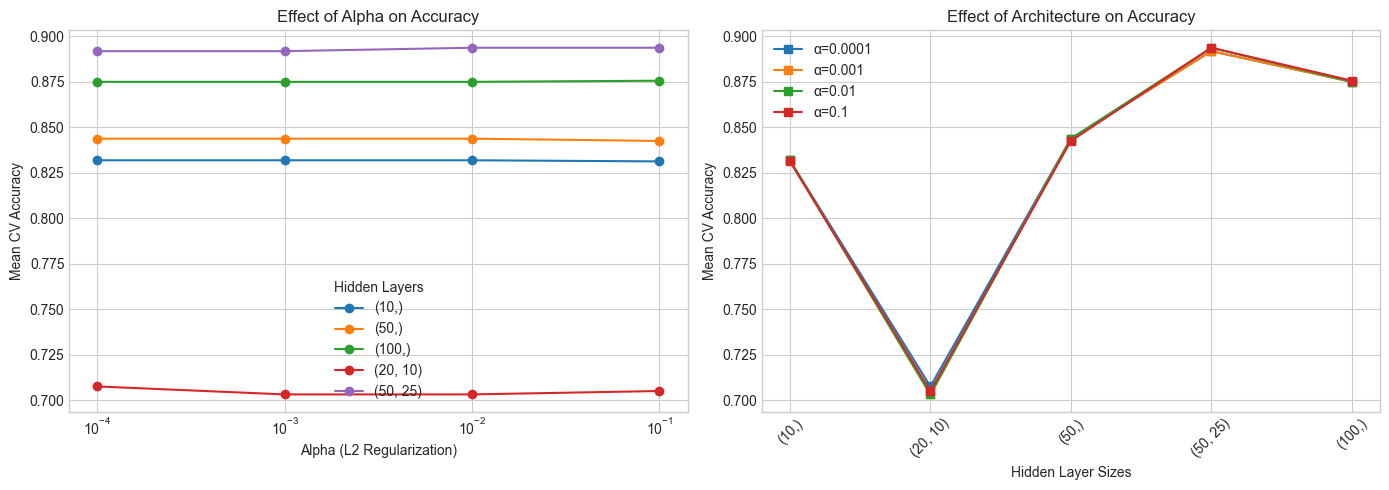

In [11]:
# Plot: Effect of alpha on accuracy for different architectures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Group by hidden layer sizes
for hl_size in param_grid['hidden_layer_sizes']:
    mask = results_df['param_hidden_layer_sizes'] == hl_size
    subset = results_df[mask].groupby('param_alpha')['mean_test_score'].mean()
    axes[0].plot(subset.index, subset.values, marker='o', label=str(hl_size))

axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (L2 Regularization)')
axes[0].set_ylabel('Mean CV Accuracy')
axes[0].set_title('Effect of Alpha on Accuracy')
axes[0].legend(title='Hidden Layers')

# Group by alpha
for alpha in param_grid['alpha']:
    mask = results_df['param_alpha'] == alpha
    subset = results_df[mask].groupby('param_hidden_layer_sizes').agg({'mean_test_score': 'mean'}).reset_index()
    x_labels = [str(hl) for hl in subset['param_hidden_layer_sizes']]
    axes[1].plot(x_labels, subset['mean_test_score'].values, marker='s', label=f'α={alpha}')

axes[1].set_xlabel('Hidden Layer Sizes')
axes[1].set_ylabel('Mean CV Accuracy')
axes[1].set_title('Effect of Architecture on Accuracy')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## 7. Best Model Decision Boundary

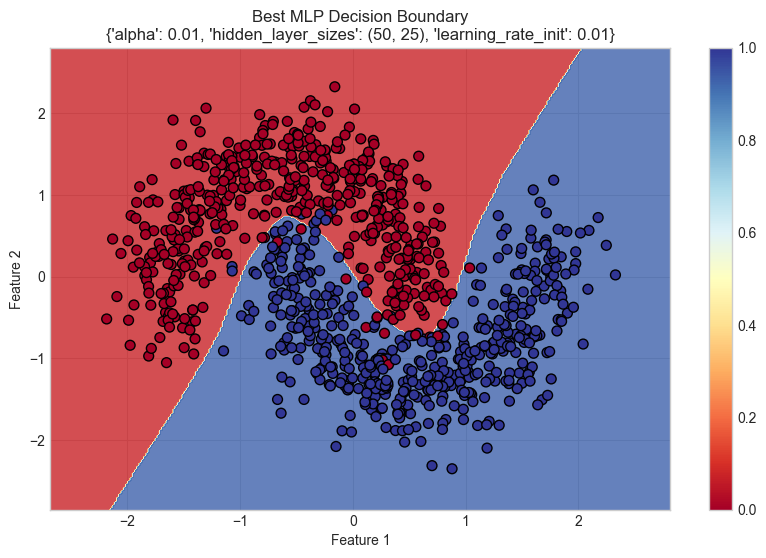

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Plot decision boundary of best model
best_model = grid_search.best_estimator_
plot_decision_boundary(
    best_model, 
    X_scaled, 
    y, 
    f"Best MLP Decision Boundary\n{grid_search.best_params_}"
)

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

## 8. Compare Architectures Visually

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 📚 モデルの学習について詳しく理解する「学習」とは、モデルがデータからパターンを見つけるプロセスです。#### 学習のプロセス1. **パターンの探索**：   - モデルは訓練データを分析して、特徴とラベルの関係を探します   - 「がく片が長くて花弁が短い → 種類A」のようなルールを見つけます2. **内部パラメータの調整**：   - モデルは見つけたパターンを内部パラメータとして記憶します   - ランダムフォレストの場合、各決定木の分岐ルールが保存されます3. **検証**：   - 訓練データで正しく分類できるか確認します   - エラーが多い場合は、パラメータを調整します#### `.fit()` メソッドの重要性```pythonmodel.fit(X_train, y_train)```この一行で以下のことが行われます：- データの統計的な特性を分析- 最適な分岐点を探索- 100本の決定木をそれぞれ構築- 各木のパラメータを最適化**実行時間**：- 小規模データ（数百〜数千行）：数秒- 中規模データ（数万行）：数十秒〜数分- 大規模データ（数十万行以上）：数分〜数時間#### 料理のたとえ学習は、料理人が何度も試作を重ねてレシピを完成させる過程に似ています：- データ = 過去の試作記録- 学習 = 記録から最適な調理法を見つける- モデル = 完成したレシピ

### 🎯 予測について詳しく理解する学習したモデルを使って、新しいデータの結果を予測します。#### 予測のプロセス1. **新しいデータの入力**：   - まだ見たことのないデータをモデルに渡します   - データは訓練時と同じ形式である必要があります2. **モデルの適用**：   - モデルは学習したパターンを新しいデータに当てはめます   - 各決定木が個別に予測を行います3. **結果の集約**：   - 100本の木の予測を多数決で決定します   - 最も多くの木が予測したクラスが最終的な予測になります#### 予測の信頼性予測には必ず不確実性があります：- **高い信頼度**：全ての木が同じクラスを予測- **低い信頼度**：木の予測が分かれる実務では、予測の確率も重要です：```python# 予測確率を取得probabilities = model.predict_proba(X_test)# 例：[0.95, 0.03, 0.02] → 95%の確率でクラス0```#### 実世界での応用**医療診断の例**：- 入力：患者の症状データ- 予測：病気の種類- 活用：医師の診断を補助（最終判断は医師が行う）**重要な注意点**：機械学習の予測は100%正確ではありません。常に人間の判断と組み合わせて使うことが重要です。

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


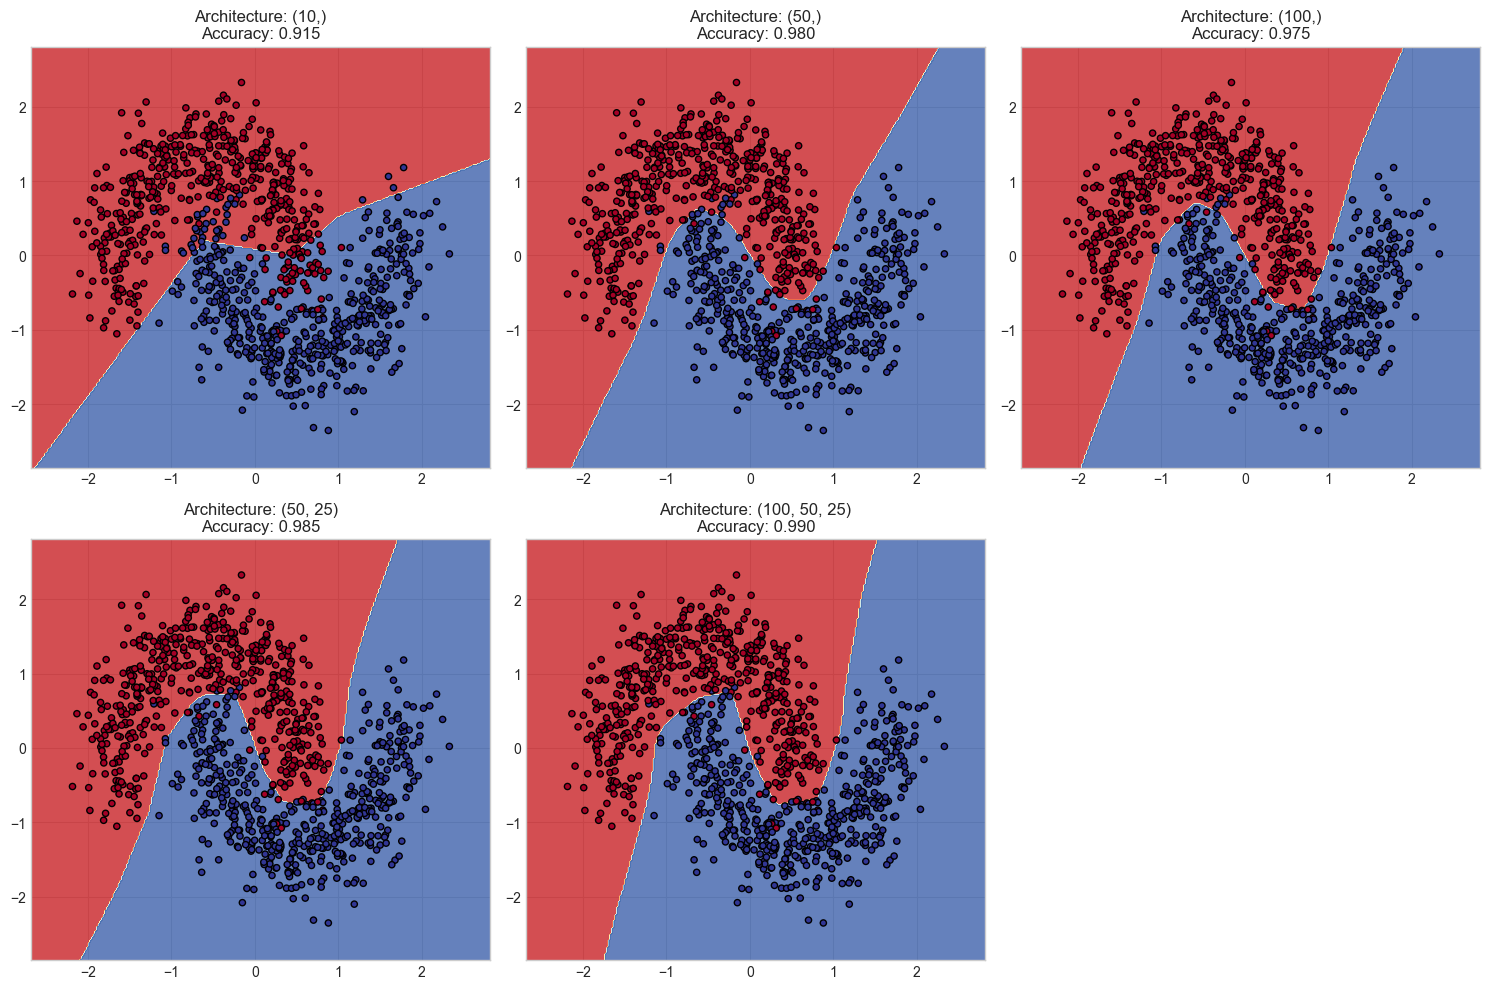

In [13]:
# Train models with different architectures and visualize
architectures = [
    (10,),
    (50,),
    (100,),
    (50, 25),
    (100, 50, 25)
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, arch in enumerate(architectures):
    # Train model
    model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Plot decision boundary
    h = 0.02
    x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.RdYlBu, 
                      edgecolors='black', s=20)
    axes[idx].set_title(f'Architecture: {arch}\nAccuracy: {model.score(X_test, y_test):.3f}')

# Hide empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

## 9. Loss Curve Analysis

### 🤖 モデルの選択について詳しく理解する機械学習のモデルは、データからパターンを見つけるための「アルゴリズム」です。道具箱から適切な工具を選ぶように、問題に応じて最適なモデルを選びます。#### ランダムフォレストとは？**ランダムフォレスト**は、初心者にもおすすめの強力なモデルです：**たとえ話**：一人の専門家に意見を聞くよりも、複数の専門家の意見を集約した方が正確な判断ができることがあります。ランダムフォレストも同じ考え方です。**仕組み**：1. たくさんの「決定木」（簡単な分類器）を作る2. 各決定木はデータの異なる部分を見る3. 全ての木の予測を多数決で決める**利点**：- 精度が高い（多くの問題で良い結果を出す）- 過学習しにくい（新しいデータでも性能が安定）- パラメータ調整が比較的簡単- データの前処理があまり必要ない**欠点**：- 学習に時間がかかることがある- モデルが大きくなりがち- 解釈が難しい（ブラックボックス）#### n_estimators=100 の意味`n_estimators=100` は「100本の決定木を作る」という意味です：- 少なすぎる（例：10本） → 精度が低い- 多すぎる（例：1000本） → 学習に時間がかかる- 100本 → バランスが良い（デフォルト値）

### 📚 モデルの学習について詳しく理解する「学習」とは、モデルがデータからパターンを見つけるプロセスです。#### 学習のプロセス1. **パターンの探索**：   - モデルは訓練データを分析して、特徴とラベルの関係を探します   - 「がく片が長くて花弁が短い → 種類A」のようなルールを見つけます2. **内部パラメータの調整**：   - モデルは見つけたパターンを内部パラメータとして記憶します   - ランダムフォレストの場合、各決定木の分岐ルールが保存されます3. **検証**：   - 訓練データで正しく分類できるか確認します   - エラーが多い場合は、パラメータを調整します#### `.fit()` メソッドの重要性```pythonmodel.fit(X_train, y_train)```この一行で以下のことが行われます：- データの統計的な特性を分析- 最適な分岐点を探索- 100本の決定木をそれぞれ構築- 各木のパラメータを最適化**実行時間**：- 小規模データ（数百〜数千行）：数秒- 中規模データ（数万行）：数十秒〜数分- 大規模データ（数十万行以上）：数分〜数時間#### 料理のたとえ学習は、料理人が何度も試作を重ねてレシピを完成させる過程に似ています：- データ = 過去の試作記録- 学習 = 記録から最適な調理法を見つける- モデル = 完成したレシピ

### 📊 評価について詳しく理解するモデルの性能を測定することは、機械学習で最も重要なステップの一つです。#### なぜ評価が必要なのか？「学習がうまくいった」だけでは不十分です。以下を確認する必要があります：- 新しいデータでも正しく予測できるか？- どのくらいの精度が出ているか？- 実用に耐えるレベルか？#### 正解率（Accuracy）とは正解率は最もシンプルな評価指標です：```正解率 = 正しく予測できた数 / 全体の数```**例**：- テストデータ：100個- 正しく予測：95個- 間違い：5個- 正解率 = 95/100 = 0.95 = 95%#### 正解率の解釈**一般的な基準**：- 90%以上：非常に良い- 80-90%：良い- 70-80%：まあまあ（改善の余地あり）- 70%未満：要改善**ただし、問題による**：- 簡単な問題：99%でも普通- 難しい問題：80%でも優秀#### 正解率だけでは不十分な場合**例：がん診断**- 全体の1%ががん患者の場合- 「全員健康」と予測しても正解率99%- しかし、がん患者を一人も見つけられない！このような場合は、他の指標（適合率、再現率など）も見る必要があります。#### 訓練データとテストデータの分割機械学習では、データを2つに分けます：- **訓練データ（70-80%）**：モデルの学習に使う- **テストデータ（20-30%）**：性能評価に使う**なぜ分けるのか？**：学校のテストと同じです。問題を見ながら答えを覚えたら、本当の理解力は測れません。

#### 🤖 モデルの選択と初期化

機械学習モデルは、データからパターンを学習するアルゴリズムです。
問題の種類に応じて、適切なモデルを選択します。

**モデル選択の考え方**：

1. **問題の種類**：
   - 分類（カテゴリー予測）→ 分類器
   - 回帰（数値予測）→ 回帰器

2. **データの特性**：
   - 線形に分離可能 → 線形モデル
   - 非線形関係 → 木モデル、ニューラルネットワーク

3. **データ量**：
   - 少量 → シンプルなモデル
   - 大量 → 複雑なモデルも使える

4. **解釈性の必要性**：
   - 必要 → 線形モデル、決定木
   - 不要 → ニューラルネットワーク

5. **計算資源**：
   - 限られている → 軽量なモデル
   - 十分にある → 複雑なモデルも可

**まずはシンプルなモデルから試す**のが鉄則です。

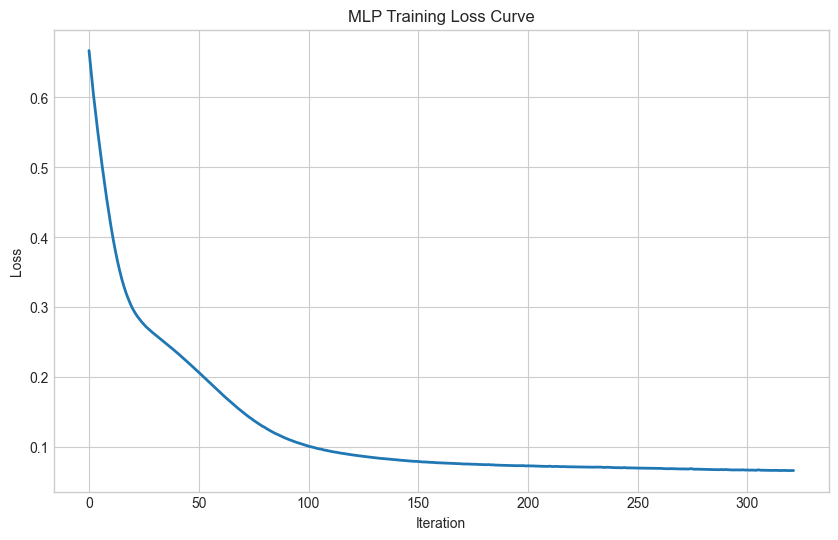

Final Loss: 0.066294
Test Accuracy: 0.9850


In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Train model and plot loss curve
mlp_loss = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

mlp_loss.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(mlp_loss.loss_curve_, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.grid(True)
plt.show()

print(f"Final Loss: {mlp_loss.loss_curve_[-1]:.6f}")
print(f"Test Accuracy: {mlp_loss.score(X_test, y_test):.4f}")

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

## Summary

In this quick start, you learned:

1. **Data Generation**: Using `make_moons` to create non-linear classification data
2. **Preprocessing**: Scaling features with `StandardScaler`
3. **MLP Training**: Using `MLPClassifier` with various parameters
4. **Parameter Exploration**: Using `GridSearchCV` for hyperparameter tuning
5. **Visualization**: Decision boundaries and loss curves

### Next Steps

- Proceed to **Notebook 01** for deeper data simulation
- Try different datasets: `make_circles`, `make_classification`
- Experiment with more parameters: `activation`, `solver`

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

**📗 Notebook 01: Data Simulation Basics** - データ生成の詳細

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
